Heart disease detection using ECG image data

Online available mendelay data set is used for this project. It can be downloaded from following links.
ECG Images dataset of Cardiac and COVID-19 Patients    https://data.mendeley.com/datasets/gwbz3fsgp8/1
ECG Images dataset of Cardiac Patients     https://data.mendeley.com/datasets/gwbz3fsgp8/2

Overall process is as follows
 
1. cropped out the necessary parts from the ECG images.
2. Remove the background
3. extract 12 leads separately
4. train the model


In [1]:
import os
import os.path
import glob
from pathlib import Path

import pandas as pd                                     
import numpy as np                                      
import matplotlib.pyplot as plt
import seaborn as sns

import cv2            
from PIL import Image
import datetime as dt
import tensorflow as tf                                 

# Scikit-learn
from sklearn.model_selection import train_test_split    
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

#Tensorflow _ Keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

## VGG Architectures 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet



There are four categories of data avaialble.
* MI - Myocardial Infarction
* HMI - History of Myocardial Infarction
* HB/ AbHb - Abnormal Heartbeat
* Normal - Normal 

necessary images and labels are extracted and stored in a dataframe using following code

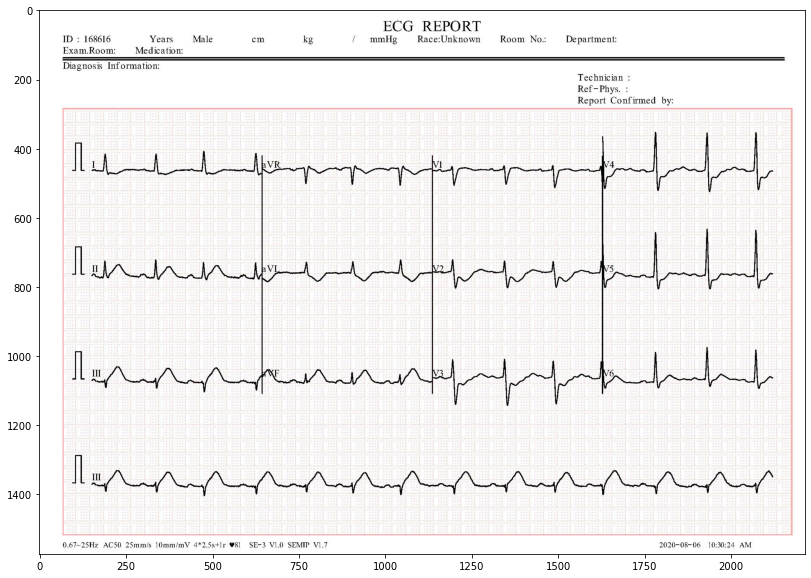

In [2]:
# MI patients data
ECG_MI_dir_ = Path('./ECG Images dataset of Cardiac Patients/ECG Images of Myocardial Infarction Patients (240x12=2880)')

ECG_MI_filepaths = list(ECG_MI_dir_.glob(r'**/*.jpg'))
# Mapping the labels
MI_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_MI_filepaths))
# Paths & labels femalee eyes
ECG_MI_filepaths = pd.Series(ECG_MI_filepaths, name = 'File').astype(str)
MI_labels = pd.Series(MI_labels, name='Label')

# Concatenating...
MI_df = pd.concat([ECG_MI_filepaths, MI_labels], axis=1)
MI_df['Label'] = "MI"

figure = plt.figure(figsize=(20,10))
x = plt.imread(MI_df["File"][0])
plt.imshow(x)
plt.show()

In [3]:
MI_df['File'][0]

'ECG Images dataset of Cardiac Patients\\ECG Images of Myocardial Infarction Patients (240x12=2880)\\MI(1).jpg'

In [4]:
# HMI patients data
ECG_HMI_dir_ = Path('./ECG Images dataset of Cardiac Patients/ECG Images of Patient that have History of MI (172x12=2064)')

ECG_HMI_filepaths = list(ECG_HMI_dir_.glob(r'**/*.jpg'))
# Mapping the labels
HMI_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_HMI_filepaths))
# Paths & labels femalee eyes
ECG_HMI_filepaths = pd.Series(ECG_HMI_filepaths, name = 'File').astype(str)
HMI_labels = pd.Series(HMI_labels, name='Label')

# Concatenating...
HMI_df = pd.concat([ECG_HMI_filepaths, HMI_labels], axis=1)
HMI_df['Label'] = "HMI"

HMI_df['File'][0]

'ECG Images dataset of Cardiac Patients\\ECG Images of Patient that have History of MI (172x12=2064)\\PMI(1).jpg'

In [5]:
# AbnHB patients data
ECG_AbnHB_dir_ = Path('./ECG Images dataset of Cardiac Patients/ECG Images of Patient that have abnormal heartbeat (233x12=2796)')

ECG_AbnHB_filepaths = list(ECG_AbnHB_dir_.glob(r'**/*.jpg'))
# Mapping the labels
AbnHB_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_AbnHB_filepaths))
# Paths & labels femalee eyes
ECG_AbnHB_filepaths = pd.Series(ECG_AbnHB_filepaths, name = 'File').astype(str)
AbnHB_labels = pd.Series(AbnHB_labels, name='Label')

# Concatenating...
AbnHB_df = pd.concat([ECG_AbnHB_filepaths, AbnHB_labels], axis=1)
AbnHB_df['Label'] = "ABNORMAL"
AbnHB_df['File'][0]

'ECG Images dataset of Cardiac Patients\\ECG Images of Patient that have abnormal heartbeat (233x12=2796)\\HB(1).jpg'

In [6]:
# Normal patients data
ECG_Normal_dir_ = Path('./ECG Images dataset of Cardiac Patients/Normal Person ECG Images (284x12=3408)')

ECG_Normal_filepaths = list(ECG_Normal_dir_.glob(r'**/*.jpg'))

       
# Mapping the labels
Normal_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_Normal_filepaths))
# Paths & labels femalee eyes
ECG_Normal_filepaths = pd.Series(ECG_Normal_filepaths, name = 'File').astype(str)
Normal_labels = pd.Series(Normal_labels, name='Label')

# Concatenating...
Normal_df = pd.concat([ECG_Normal_filepaths, Normal_labels], axis=1)
Normal_df['Label'] = "NORMAL"
Normal_df["File"][0]

'ECG Images dataset of Cardiac Patients\\Normal Person ECG Images (284x12=3408)\\Normal(1).jpg'

In [7]:
# concat
df_ECG = pd.concat([MI_df, HMI_df, AbnHB_df,Normal_df],ignore_index=True)
df_ECG

,File,Label
0,ECG Images dataset of Cardiac Patients\ECG Ima...,MI
1,ECG Images dataset of Cardiac Patients\ECG Ima...,MI
2,ECG Images dataset of Cardiac Patients\ECG Ima...,MI
3,ECG Images dataset of Cardiac Patients\ECG Ima...,MI
4,ECG Images dataset of Cardiac Patients\ECG Ima...,MI
...,...,...
923,ECG Images dataset of Cardiac Patients\Normal ...,NORMAL
924,ECG Images dataset of Cardiac Patients\Normal ...,NORMAL
925,ECG Images dataset of Cardiac Patients\Normal ...,NORMAL
926,ECG Images dataset of Cardiac Patients\Normal ...,NORMAL


below function is used to crop the images.

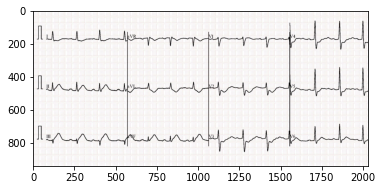

In [8]:
def crop_image(image, left = 71.5, top = 287.5, right = 2102, bottom = 1228):
    img = Image.open(image)
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img

plt.imshow(crop_image(df_ECG["File"][0]))
plt.show()

In [9]:
def remove_background(image,name):
  
    img = np.asarray(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold input image as mask
    mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]
    mask = 255 - mask

    # apply morphology to remove isolated extraneous noise. use borderconstant of black since foreground touches the edges
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # anti-alias the mask -- blur then stretch. blur alpha channel
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

    # linear stretch so that 127.5 goes to 0, but 255 stays 255
    mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

    result = img.copy()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = mask
#     cv2.imshow('gray', result)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cv2.imwrite('./preprocessd_images/outECG/'+ str(name), result)

    result = Image.fromarray(result)
    return result

In [10]:
def get_processed_image(df, folder_name):
    image = []
    name = []
    
    for i in range(0, df.shape[0]):
        filepath = df["File"][i]
        filename = filepath.split('\\')[2]
        output = remove_background(crop_image(filepath), folder_name + str(filename))
        image.append(output)
        name.append(filename)
    
    new_dataframe = pd.DataFrame(image, columns = ['PilImage'])
    new_dataframe['filename']= name
    new_dataframe['filename'].replace({"\(":"_",'\).jpg':''}, regex=True,inplace=True)
    return new_dataframe

MI_c_bg_df = get_processed_image(MI_df,'MI_c_bg/')
HMI_c_bg_df = get_processed_image(HMI_df,'HMI_c_bg/')
Normal_c_bg_df = get_processed_image(Normal_df,'Normal_c_bg/')
AbnHB_c_bg_df = get_processed_image(AbnHB_df,'AbnHB_c_bg/')

In [11]:
MI_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_102


In [12]:
HMI_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_102


In [13]:
Normal_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_102


In [14]:
AbnHB_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_102


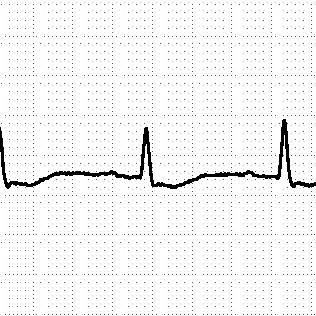

In [15]:
image=MI_c_bg_df["PilImage"][0]
width= 315
height= 315
image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L')

Below function is used to extract 12 leads from the ECG data

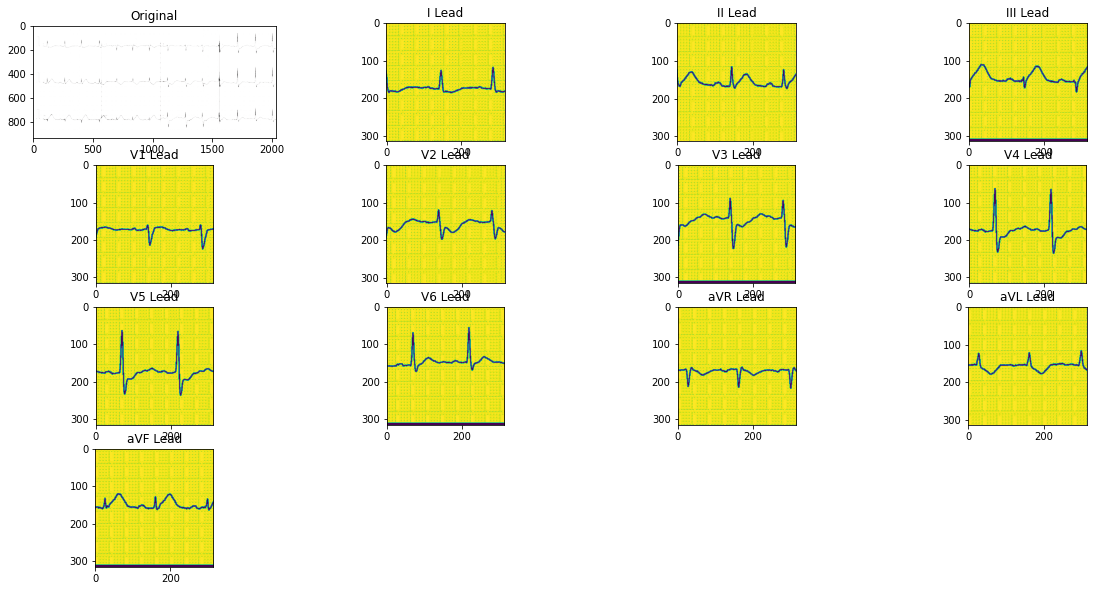

In [16]:
    image=MI_c_bg_df["PilImage"][0]
    width= 315
    height= 315
    I_img   = image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L') # Converting Images to Grayscale
    II_img  = image.crop((120.5, 315.5, width + 120.5 , 315.5+ height)).convert('L')
    III_img = image.crop((120.5, 630.5, width + 120.5 , 630.5+ height)).convert('L')
    aVR_img = image.crop((672.5, 0.5, width + 672.5 , 0.5 + height)).convert('L')
    aVL_img = image.crop((672.5, 315.5, width + 672.5 , 315.5+ height)).convert('L')
    aVF_img = image.crop((672.5, 630.5, width + 672.5 , 630.5+ height)).convert('L')
    V1_img  = image.crop((1133.5, 0.5, width + 1133.5 , 0.5+ height)).convert('L')
    V2_img  = image.crop((1133.5, 315.5, width + 1133.5 , 315.5+ height)).convert('L')
    V3_img  = image.crop((1133.5, 630.5, width + 1133.5 , 630.5+ height)).convert('L')
    V4_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5 + height)).convert('L')
    V5_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5+ height)).convert('L')
    V6_img  = image.crop((1639.5, 630.5, width + 1639.5 , 630.5+ height)).convert('L')
    

    plt.figure(figsize=(20,10))
    plt.subplot(4,4,1)
    plt.imshow(image)
    plt.title("Original")

    plt.subplot(4,4,2)
    plt.imshow(I_img)
    plt.title("I Lead")
  
    plt.subplot(4,4,3)
    plt.imshow(II_img)
    plt.title("II Lead")

    plt.subplot(4,4,4)
    plt.imshow(III_img)
    plt.title("III Lead")

    plt.subplot(4,4,5)
    plt.imshow(V1_img)
    plt.title("V1 Lead")

    plt.subplot(4,4,6)
    plt.imshow(V2_img)
    plt.title("V2 Lead")

    plt.subplot(4,4,7)
    plt.imshow(V3_img)
    plt.title("V3 Lead")

    plt.subplot(4,4,8)
    plt.imshow(V4_img)
    plt.title("V4 Lead")

    plt.subplot(4,4,9)
    plt.imshow(V5_img)
    plt.title("V5 Lead")

    plt.subplot(4,4,10)
    plt.imshow(V6_img)
    plt.title("V6 Lead")

    plt.subplot(4,4,11)
    plt.imshow(aVR_img)
    plt.title("aVR Lead")

    plt.subplot(4,4,12)
    plt.imshow(aVL_img)
    plt.title("aVL Lead")

    plt.subplot(4,4,13)
    plt.imshow(aVF_img)
    plt.title("aVF Lead")

    plt.show()
    

In [17]:
def save_12leads_segments(image,folder,name, width= 315, height= 315):

    # Segment 12 Leads 
    I_img   = image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L') # Converting Images to Grayscale
    II_img  = image.crop((120.5, 315.5, width + 120.5 , 315.5+ height)).convert('L')
    III_img = image.crop((120.5, 630.5, width + 120.5 , 630.5+ height)).convert('L')
    aVR_img = image.crop((672.5, 0.5, width + 672.5 , 0.5 + height)).convert('L')
    aVL_img = image.crop((672.5, 315.5, width + 672.5 , 315.5+ height)).convert('L')
    aVF_img = image.crop((672.5, 630.5, width + 672.5 , 630.5+ height)).convert('L')
    V1_img  = image.crop((1133.5, 0.5, width + 1133.5 , 0.5+ height)).convert('L')
    V2_img  = image.crop((1133.5, 315.5, width + 1133.5 , 315.5+ height)).convert('L')
    V3_img  = image.crop((1133.5, 630.5, width + 1133.5 , 630.5+ height)).convert('L')
    V4_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5 + height)).convert('L')
    V5_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5+ height)).convert('L')
    V6_img  = image.crop((1639.5, 630.5, width + 1639.5 , 630.5+ height)).convert('L')
    
    
    # Negative leads I,II,III, aVR,aVL,aVF
    
    I_neg_img   = Image.fromarray(cv2.flip(np.asarray(I_img),0)) # Vertical Flip
    II_neg_img  = Image.fromarray(cv2.flip(np.asarray(II_img),0)) # Vertical Flip
    III_neg_img = Image.fromarray(cv2.flip(np.asarray(III_img),0)) # Vertical Flip
    aVR_neg_img = Image.fromarray(cv2.flip(np.asarray(aVR_img),0)) # Vertical Flip
    aVL_neg_img = Image.fromarray(cv2.flip(np.asarray(aVL_img),0)) # Vertical Flip
    aVF_neg_img = Image.fromarray(cv2.flip(np.asarray(aVL_img),0)) # Vertical Flip
    
    
    # Save 12 leads to respective folder
    
    I_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/I/')+ str(name)+str('.png'))   
    I_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/I_Neg/')+ str(name)+str('.png'))
    II_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/II/')+ str(name)+str('.png'))
    II_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/II_Neg/')+ str(name)+str('.png'))
    III_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/III/')+ str(name)+str('.png'))
    III_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/III_Neg/')+ str(name)+str('.png'))
    aVR_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVR/')+ str(name)+str('.png'))
    aVR_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVR_Neg/')+ str(name)+str('.png'))
    aVL_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVL/')+ str(name)+str('.png'))
    aVL_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVL_Neg/')+ str(name)+str('.png'))
    aVF_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVF/')+ str(name)+str('.png'))
    aVF_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVF_Neg/')+ str(name)+str('.png'))
    V1_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V1/')+ str(name)+str('.png'))
    V2_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V2/')+ str(name)+str('.png'))
    V3_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V3/')+ str(name)+str('.png'))
    V4_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V4/')+ str(name)+str('.png'))
    V5_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V5/')+ str(name)+str('.png'))
    V6_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V6/')+ str(name)+str('.png'))


In [18]:
for i in range(0,MI_c_bg_df.shape[0]):
    save_12leads_segments(image=MI_c_bg_df["PilImage"][i],folder='MI', name= str(MI_c_bg_df["filename"][i]))
for i in range(0,HMI_c_bg_df.shape[0]):
    save_12leads_segments(image=HMI_c_bg_df["PilImage"][i],folder='HMI', name= str(HMI_c_bg_df["filename"][i]))
for i in range(0,AbnHB_c_bg_df.shape[0]):
    save_12leads_segments(image=AbnHB_c_bg_df["PilImage"][i],folder='AbnHB', name= str(AbnHB_c_bg_df["filename"][i]))
for i in range(0,Normal_c_bg_df.shape[0]):
    save_12leads_segments(image=Normal_c_bg_df["PilImage"][i],folder='Normal', name= str(Normal_c_bg_df["filename"][i]))


In [19]:
import fnmatch
fnames = []
for path, dirs, files in os.walk(os.path.abspath(r"./preprocessd_images/ECG_leads/AbnHB/aVF/")):
    for filename in fnmatch.filter(files, "*.png"):
        #print(filename)
        fnames.append(filename)
print(len(fnames))

233


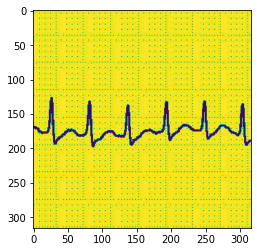

In [20]:
x = plt.imread(r"./preprocessd_images/ECG_leads/AbnHB/I/HB_31.png")
plt.imshow(x)

In [21]:
def get_12leads_to_df(root_folder):
    filepaths = []
    filenames = []
    folders = [os.path.join(root_folder, x) for x in ('I', 'I_Neg','II', 'II_Neg','III', 'III_Neg','aVR', 'aVR_Neg','aVL', 'aVL_Neg','aVF', 'aVF_Neg','V1','V2','V3','V4','V5','V6' )]
    for folder in folders:
        for filename in os.listdir(folder):
            if filename.endswith(".png"):
                fp =os.path.join(folder, filename)
                filepaths.append(fp)
                filenames.append(filename)
    df = pd.DataFrame(filenames, columns = ['filename'])
    df['filepaths'] = filepaths
    df['label'] = root_folder.split('/')[-2]
    return df

In [22]:
MI = get_12leads_to_df('./preprocessd_images/ECG_leads/MI/')
HMI  = get_12leads_to_df('./preprocessd_images/ECG_leads/HMI/')
AbnHB  = get_12leads_to_df('./preprocessd_images/ECG_leads/AbnHB/')
Normal =  get_12leads_to_df('./preprocessd_images/ECG_leads/Normal/')

In [23]:
HMI

,filename,filepaths,label
0,PMI_1.png,./preprocessd_images/ECG_leads/HMI/I\PMI_1.png,HMI
1,PMI_10.png,./preprocessd_images/ECG_leads/HMI/I\PMI_10.png,HMI
2,PMI_100.png,./preprocessd_images/ECG_leads/HMI/I\PMI_100.png,HMI
3,PMI_101.png,./preprocessd_images/ECG_leads/HMI/I\PMI_101.png,HMI
4,PMI_102.png,./preprocessd_images/ECG_leads/HMI/I\PMI_102.png,HMI
...,...,...,...
3091,PMI_95.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_95.png,HMI
3092,PMI_96.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_96.png,HMI
3093,PMI_97.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_97.png,HMI
3094,PMI_98.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_98.png,HMI


In [24]:
df = pd.concat([MI, HMI, AbnHB,Normal],ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16704 entries, 0 to 16703
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   16704 non-null  object
 1   filepaths  16704 non-null  object
 2   label      16704 non-null  object
dtypes: object(3)
memory usage: 391.6+ KB


C:\Users\Malitha\anaconda3\envs\keras_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


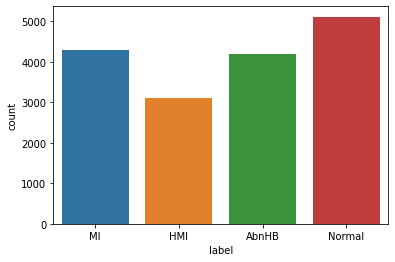

In [25]:
sns.countplot(df["label"])
plt.show();

In [27]:
# select random 3000 samples from each class
df1 = df.copy()
df1_1 = df1[df1['label'] == 'MI'].sample(3000)
df1_2 = df1[df1['label'] == 'HMI'].sample(3000)
df1_3 = df1[df1['label'] == 'AbnHB'].sample(3000)
df1_4 = df1[df1['label'] == 'Normal'].sample(3000)
df_3K = pd.concat([df1_1, df1_2, df1_3,df1_4],ignore_index=True)

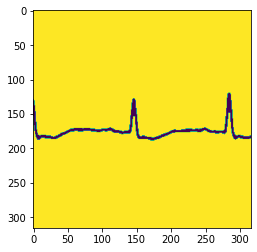

In [28]:
def salt(img, n):
    for k in range(n):
        i = int(np.random.random() * img.shape[1])
        j = int(np.random.random() * img.shape[0])
        if img.ndim == 2:
            img[j,i] = 255
        elif img.ndim == 3:
            img[j,i,0]= 255
            img[j,i,1]= 255
            img[j,i,2]= 255
        return img
    
def bg_remov(image):
    result = salt(image, 10)
    median = cv2.medianBlur(result,5)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 85, 255, cv2.THRESH_BINARY)
    return blackAndWhiteImage

img_array = cv2.imread(df['filepaths'][0])   # converting the image to gray scale
img_array = bg_remov(img_array)
plt.imshow(img_array)

In [29]:
le = LabelEncoder()
df_3K["label"] = le.fit_transform(df_3K["label"])
df_3K

,filename,filepaths,label
0,MI_89.png,./preprocessd_images/ECG_leads/MI/V5\MI_89.png,2
1,MI_142.png,./preprocessd_images/ECG_leads/MI/V4\MI_142.png,2
2,MI_53.png,./preprocessd_images/ECG_leads/MI/V6\MI_53.png,2
3,MI_33.png,./preprocessd_images/ECG_leads/MI/V6\MI_33.png,2
4,MI_223.png,./preprocessd_images/ECG_leads/MI/II\MI_223.png,2
...,...,...,...
11995,Normal_237.png,./preprocessd_images/ECG_leads/Normal/aVL_Neg\...,3
11996,Normal_154.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,3
11997,Normal_158.png,./preprocessd_images/ECG_leads/Normal/aVF\Norm...,3
11998,Normal_42.png,./preprocessd_images/ECG_leads/Normal/aVR_Neg\...,3


In [57]:
df["label"].value_counts()

Normal    5112
MI        4302
AbnHB     4194
HMI       3096
Name: label, dtype: int64

In [30]:
x = plt.imread(df_3K['filepaths'][0])
x.shape

(316, 314)

In [31]:
data = []   
image_size = 100
for i in range(len(df_3K)):
    img_array = cv2.imread(df_3K['filepaths'][i])  
    img_array = bg_remov(img_array)
    new_img_array = cv2.resize(img_array, (image_size, image_size)) 
    data.append([new_img_array, df_3K['label'][i]])

In [32]:
np.random.shuffle(data)
x = []
y = []
for i in data:
    x.append(i[0])
    y.append(i[1])
x = np.array(x).reshape(-1, 100, 100, 1)
y = np.array(y)

In [33]:
X_train, X_dum, y_train, y_dum=train_test_split(x,y, train_size=0.8, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test=train_test_split(X_dum, y_dum, train_size= 0.5, shuffle=True, random_state=42)

X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train.shape, X_val.shape,X_test.shape

((9600, 100, 100, 1), (1200, 100, 100, 1), (1200, 100, 100, 1))

In [34]:
# X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state = 42)
# X_train = X_train.astype('float32')/255
# X_val = X_val.astype('float32')/255
# X_train.shape, X_val.shape

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D, MaxPool2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

# from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

C:\Users\Malitha\AppData\Local\Temp\ipykernel_10320\3909733348.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape = (100, 100, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(optimizer ='adam',
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 64)                2

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# checkpoint = ModelCheckpoint('ECGdetetcionModel.h5',
#                              monitor='val_loss',
#                              mode='min',
#                              save_best_only=True,
#                              verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

allChecks = [earlystop, reduce_lr]

In [38]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,  callbacks=allChecks,validation_data=(X_val, y_val))

Epoch 1/50
75/75 [==============================] - 40s 518ms/step - loss: 1.3885 - accuracy: 0.2776 - val_loss: 1.3038 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 39s 517ms/step - loss: 1.2065 - accuracy: 0.4489 - val_loss: 1.1536 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 39s 516ms/step - loss: 1.0454 - accuracy: 0.5429 - val_loss: 1.0425 - val_accuracy: 0.5592 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 39s 514ms/step - loss: 0.8846 - accuracy: 0.6350 - val_loss: 0.9334 - val_accuracy: 0.6242 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 38s 513ms/step - loss: 0.7408 - accuracy: 0.7023 - val_loss: 0.8119 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 38s 511ms/step - loss: 0.6302 - accuracy: 0.7554 - val_loss: 0.8055 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 38s 513ms/st

In [41]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

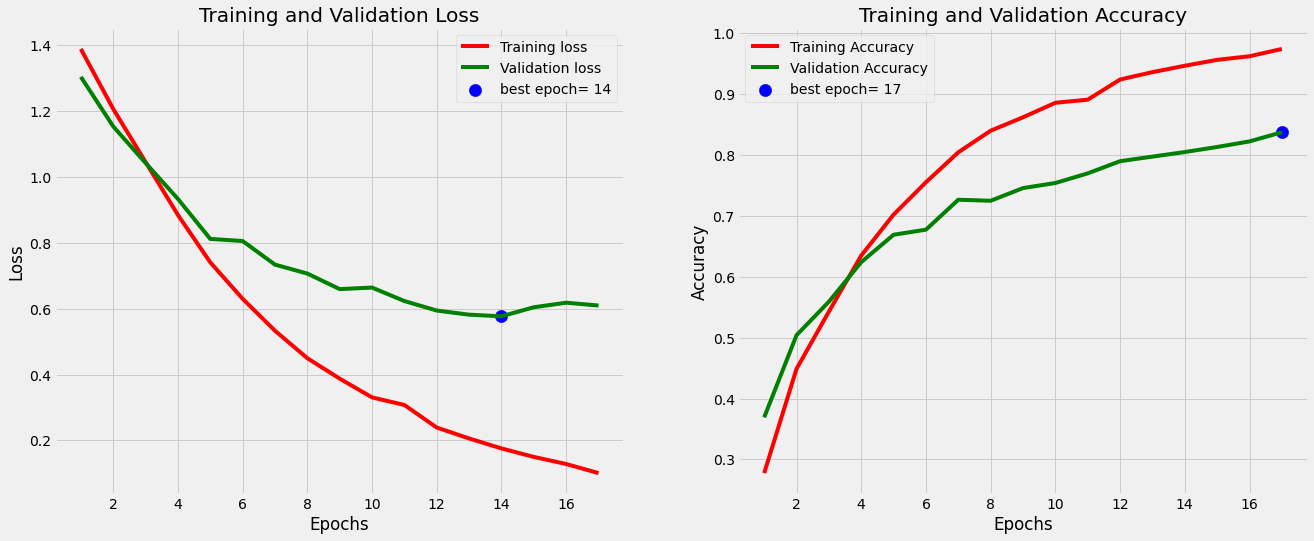

In [42]:
tr_plot(history,0)

In [44]:
score = model.evaluate(X_val, y_val)
print("test loss ", score[0])
print("test accuracy ", score[1])

38/38 [==============================] - 2s 45ms/step - loss: 0.5769 - accuracy: 0.8050
test loss  0.5769149661064148
test accuracy  0.8050000071525574


In [45]:
prediction = model.predict(X_test)
prediction

38/38 [==============================] - 2s 45ms/step


array([[9.5700700e-04, 2.6147789e-03, 9.9616158e-01, 2.6658969e-04],
       [6.8665884e-04, 5.0751641e-03, 9.9384236e-01, 3.9579789e-04],
       [9.9823511e-01, 1.5237831e-03, 1.1037627e-06, 2.4003460e-04],
       ...,
       [2.1951427e-01, 3.4502330e-01, 9.7895076e-04, 4.3448347e-01],
       [5.0907484e-03, 1.6521471e-05, 9.9482757e-01, 6.5174470e-05],
       [4.6105674e-03, 9.5106208e-01, 1.2717474e-03, 4.3055613e-02]],
      dtype=float32)

In [68]:
predictions = []
for i in prediction:
    predictions.append(int(np.argmax(i)))
#     print(int(np.argmax(prediction[i])), y_test[i])
#     print(le.inverse_transform([np.argmax(prediction[i])]))
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       313
           1       0.75      0.74      0.74       291
           2       0.94      1.00      0.97       271
           3       0.79      0.78      0.79       325

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



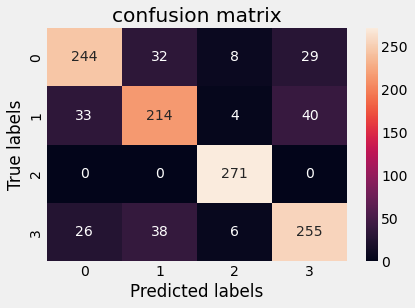

In [77]:
cm = confusion_matrix( y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g');
plt.title("confusion matrix")
plt.xlabel('Predicted labels')
plt.ylabel('True labels'); 